# Importing Libraries, Data, and setting it up for analysis

In [ ]:
# تغییر توسط wayne-amr - ۱۴ ژوئن ۲۰۲۵
print("Hello from wayne-amr!")
# import the libraries and tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# store the data frame in a variable
df = pd.read_csv('C:\\dev\\lung_cancer_analysis\\lung_cancer_data.csv')

# convert YES and NO values to numerical binary values 1 and 0 ( feature encoding also known as binary-encoding/label-encoding)
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'YES': 1, 'NO': 0})


# Comparing different model metrics

In [13]:
# Separate features and target variable
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48, stratify=y)

# Verify the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=48, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=48),
    "Random Forest": RandomForestClassifier(random_state=48),
    "Gradient Boosting": GradientBoostingClassifier(random_state=48),
    "SVM": SVC(probability=True, random_state=48),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Dictionary to store model performances
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # Calculate evaluation metrics
    performance = {
        "F1 Score": round(f1_score(y_test, y_pred) * 100, 2),
        "Recall": round(recall_score(y_test, y_pred) * 100, 2), 
        "Accuracy": round(accuracy_score(y_test, y_pred) * 100, 2),
        "Precision": round(precision_score(y_test, y_pred) * 100, 2),
        "ROC-AUC": round(roc_auc_score(y_test, y_prob) * 100, 2)
    }
    
    # Store the performance
    model_performance[model_name] = performance

# Convert performance dictionary to a DataFrame for easier comparison
performance_df = pd.DataFrame(model_performance).T
performance_df.sort_values(by="ROC-AUC", ascending=True)

,F1 Score,Recall,Accuracy,Precision,ROC-AUC
Naive Bayes,94.79,95.88,90.79,93.72,91.99
SVM,93.26,100.00,87.37,87.37,93.24
Logistic Regression,92.39,86.83,87.51,98.71,94.78
Gradient Boosting,98.59,98.87,97.53,98.31,99.43
Random Forest,99.77,99.54,99.60,100.00,100.00
Decision Tree,99.77,99.54,99.60,100.00,100.00
KNN,99.85,100.00,99.73,99.69,100.00


Accuracy: Balanced datasets or when all errors have equal costs.

Precision:	When false positives are more costly than false negatives (e.g., email spam).

Recall:	When false negatives are more costly than false positives (e.g., disease detection).

F1-Score:	When you need a balance between precision and recall, especially on imbalanced datasets.

ROC-AUC:	When comparing model performance across multiple thresholds or for imbalanced datasets.

# Logistic-Regression model 

In [2]:
# Define features (X) and target variable (y)
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate ROC-AUC if supported by the model
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = roc_auc_score(y_test, model.decision_function(X_test))

# Print metrics
print("Accuracy:    ", accuracy * 100, "%")
print("Recall Score:", recall * 100, "%")
print("Precision:   ", precision * 100, "%")
print("F1-score:    ", f1 * 100, "%")
print("ROC-AUC:     ", roc_auc * 100, "%")

# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

Accuracy:     92.53932584269663 %
Recall Score: 98.10450819672131 %
Precision:    93.68884540117418 %
F1-score:     95.84584584584584 %
ROC-AUC:      94.12512009848075 %
Cross-validation scores: [0.93533487 0.91098266 0.91560694 0.90982659 0.91213873 0.92023121]
Mean Cross-Validation Score: 0.9173535000244742


# Improving the metrics on the Logistic-Regression model 

In [3]:
# Check the balance of the target variable (LUNG_CANCER)
class_distribution = y.value_counts(normalize=True) * 100

# Display class distribution as text
class_distribution


LUNG_CANCER
1    87.378641
0    12.621359
Name: proportion, dtype: float64

In [4]:
from imblearn.over_sampling import SMOTE

# Define features (X) and target variable (y)
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))


Before SMOTE: Counter({1: 4528, 0: 663})
After SMOTE: Counter({1: 4528, 0: 4528})


In [5]:
# removed certain parameters to have smaller feature columns
df = df.drop(['YELLOW_FINGERS', 'SWALLOWING_DIFFICULTY', 'SMOKING'], axis=1)
# change the test size and random state to find the best accuracy score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=3)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = roc_auc_score(y_test, model.decision_function(X_test))
print("Accuracy:    ", accuracy * 100, "%")
print("Recall Score:", recall * 100, "%")
print("Precision:   ", precision * 100, "%")
print("F1-score:    ", f1 * 100, "%")
print("ROC-AUC:     ", roc_auc * 100, "%")
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

Accuracy:     95.4177897574124 %
Recall Score: 99.07692307692308 %
Precision:    95.83333333333334 %
F1-score:     97.42813918305598 %
ROC-AUC:      96.65551839464884 %
Cross-validation scores: [0.93021277 0.92163543 0.9241908  0.92248722 0.91567291 0.92248722]
Mean Cross-Validation Score: 0.9227810600843332


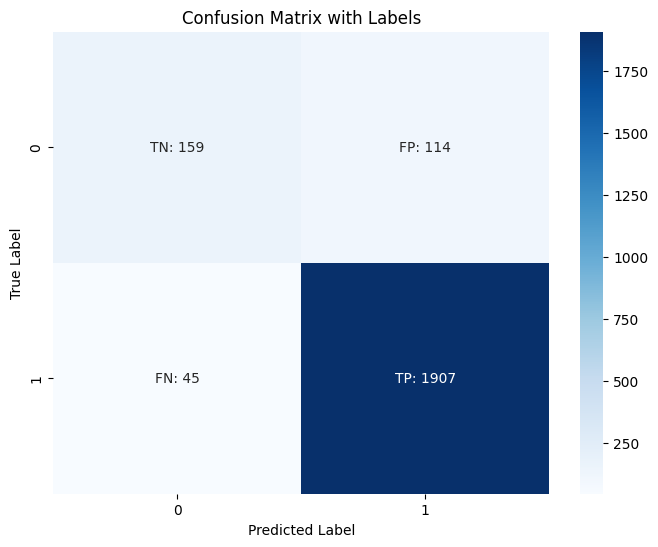

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define features (X) and target variable (y)
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a labeled confusion matrix
labels = [
    [f"TN: {cm[0, 0]}", f"FP: {cm[0, 1]}"],
    [f"FN: {cm[1, 0]}", f"TP: {cm[1, 1]}"]
]

# Plot the confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix with Labels')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Decision Tree Classifier Model

In [8]:
# Features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_proba) * 100


# Print metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")

# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())
print('')

# Export tree structure as text
print(export_text(model, feature_names=list(X.columns)))


Accuracy: 99.06%
Precision: 99.61%
Recall: 99.31%
F1 Score: 99.46%
ROC-AUC Score: 99.96%
Cross-validation scores: [0.99393327 0.98685541 0.98786653 0.98988878 0.9888664  0.98684211]
Mean Cross-Validation Score: 0.989042080974389

|--- ALCOHOL_CONSUMING <= 0.50
|   |--- PEER_PRESSURE <= 0.50
|   |   |--- CHRONIC_DISEASE <= 0.50
|   |   |   |--- CHEST_PAIN <= 0.50
|   |   |   |   |--- AGE <= 55.50
|   |   |   |   |   |--- ANXIETY <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- ANXIETY >  0.50
|   |   |   |   |   |   |--- AGE <= 52.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- AGE >  52.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- AGE >  55.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- CHEST_PAIN >  0.50
|   |   |   |   |--- AGE <= 55.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- AGE >  55.50
|   |   |   |   |   |--- SHORTNESS_OF_BREATH <= 0.50
|   |   |   |   |   |   |--- WHEEZING <= 0.50
|   |   

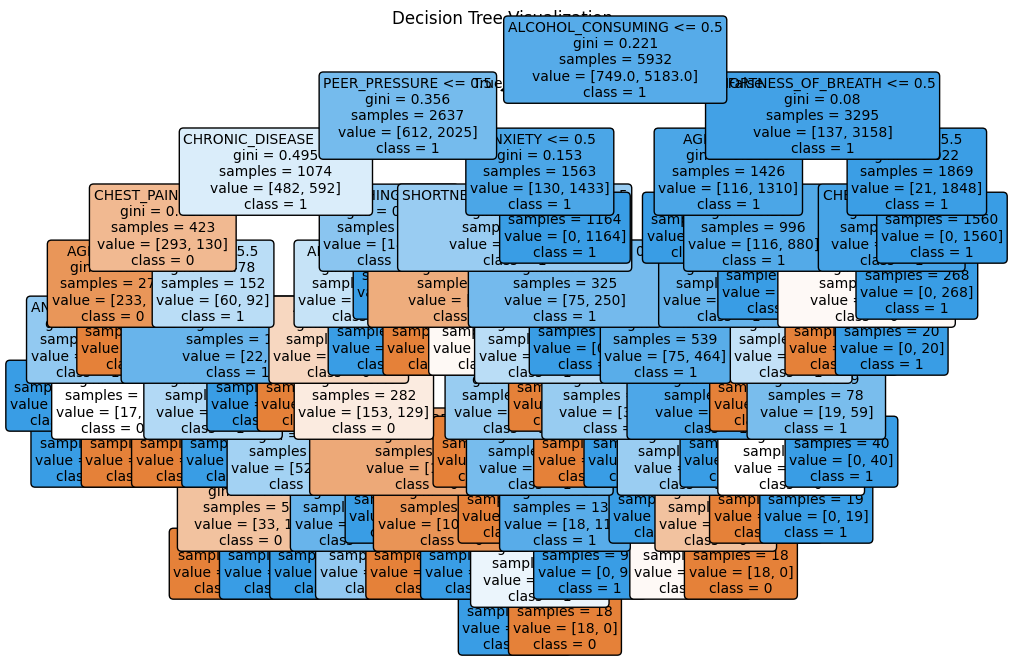

In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=model.classes_.astype(str),
    filled=True,  # Colors the nodes by class
    rounded=True,  # Rounds the boxes for better readability
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


# Random Forest Model

In [10]:
# Features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_proba) * 100

# Print metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")

# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

Accuracy: 99.06%
Precision: 99.61%
Recall: 99.31%
F1 Score: 99.46%
ROC-AUC Score: 99.96%
Cross-validation scores: [0.99393327 0.98685541 0.98786653 0.98988878 0.9888664  0.98684211]
Mean Cross-Validation Score: 0.989042080974389


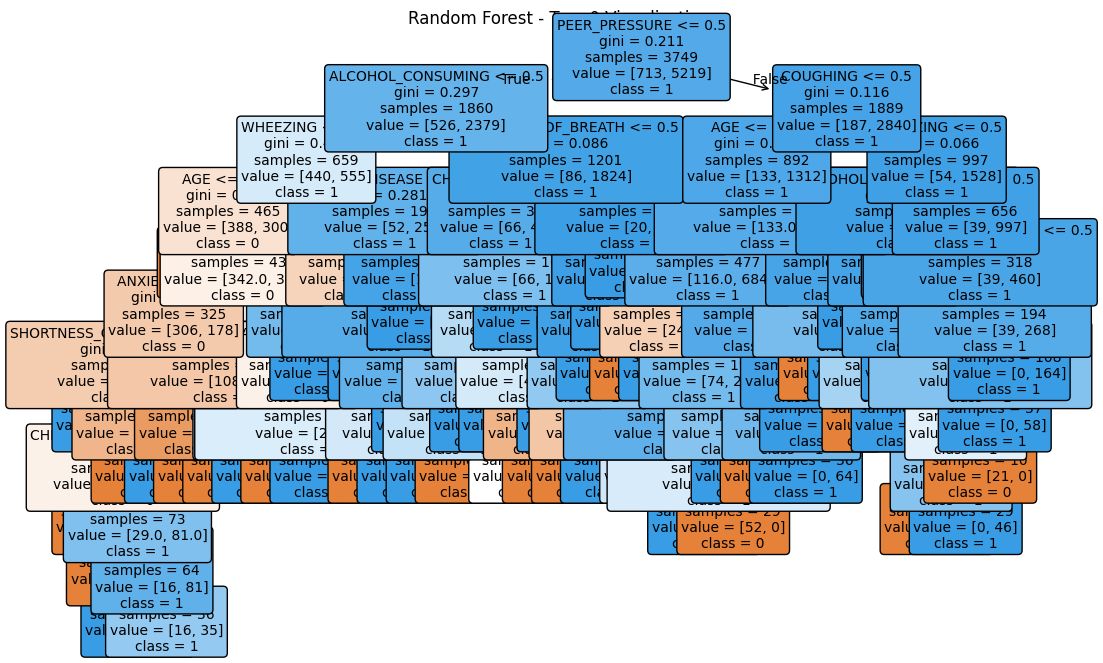

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize one tree from the Random Forest
plt.figure(figsize=(12, 8))
plot_tree(
    model.estimators_[0],  # Access the first tree in the ensemble
    feature_names=X.columns,
    class_names=model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Random Forest - Tree 0 Visualization")
plt.show()


# Gradient Boosting Model

In [47]:

# Features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_proba) * 100

# Print metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")

# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

Accuracy: 97.17%
Precision: 97.07%
Recall: 99.77%
F1 Score: 98.40%
ROC-AUC Score: 99.75%
Cross-validation scores: [0.97876643 0.9817998  0.97371082 0.97168857 0.97165992 0.97975709]
Mean Cross-Validation Score: 0.9762304376481376


# SVM (Support Vector Machine) Model

In [48]:
# Features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Support Vector Machine Classifier
model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_proba) * 100

# Print metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")


# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())


Accuracy: 87.40%
Precision: 87.40%
Recall: 100.00%
F1 Score: 93.28%
ROC-AUC Score: 87.76%
Cross-validation scores: [0.87360971 0.87360971 0.87360971 0.87360971 0.87348178 0.87449393]
Mean Cross-Validation Score: 0.8737357559333506


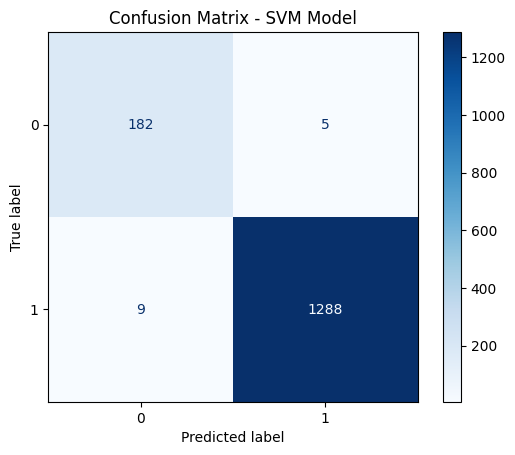

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - SVM Model')
plt.show()


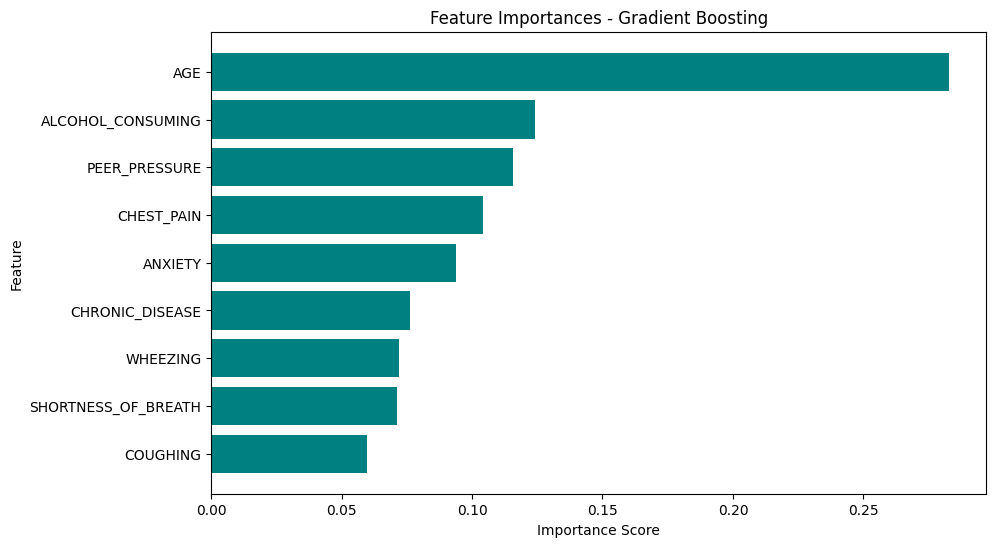

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importances
importances = model.feature_importances_
indices = np.argsort(importances)  # Sort feature importances
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names[indices], importances[indices], color='teal')
plt.title('Feature Importances - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


# Improving the SVM metrics

In [52]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features ( scale the data so that it has a mean of 0 and a standard deviation to 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")


Accuracy: 97.37%
Precision: 99.14%
Recall: 97.85%
F1 Score: 98.49%
ROC-AUC Score: 98.74%


# KNN (K-Nearest Neighbors) Model

In [53]:
# Features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust 'n_neighbors' as needed
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_pred_prob = knn.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100

# Print metrics with 2 decimal points
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")


Accuracy: 98.99%
Precision: 99.69%
Recall: 99.16%
F1 Score: 99.42%
ROC-AUC Score: 99.94%


# Naive Bayes Model

In [ ]:
# Features and target
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Make predictions
y_pred = nb.predict(X_test)
y_pred_prob = nb.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100

# Print metrics with 2 decimal points
print(f"F1 Score: {f1:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")


F1 Score: 93.67%
Accuracy: 88.14%
Recall: 100.00%
Precision: 88.10%
ROC-AUC Score: 53.06%


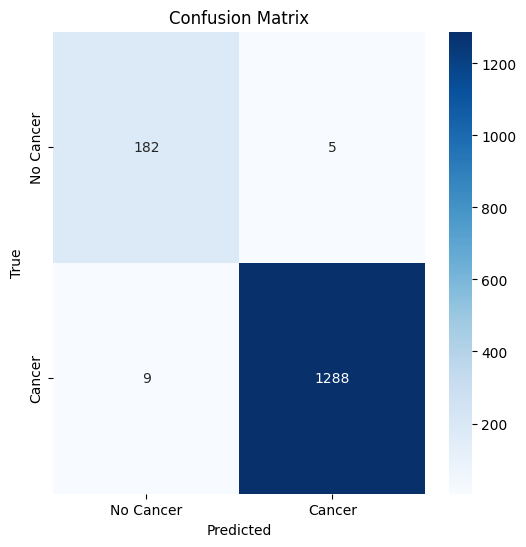

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



# Imporving the Naive Bayes Model

In [ ]:
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA for dimensionality reduction (principle component analysis)
pca = PCA(n_components=0.95)  # Choose the number of components to retain 95% of variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
y_pred_prob = nb.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100
print(f"F1 Score: {f1:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"ROC-AUC Score: {roc_auc:.2f}%")


F1 Score: 95.49%
Accuracy: 92.05%
Recall: 95.86%
Precision: 95.13%
ROC-AUC Score: 92.01%


In [ ]:
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
y_pred_prob = nb.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
roc_auc = roc_auc_score(y_test, y_pred_prob) * 100  
print(f"F1 Score: {f1:.2f}%") 
print(f"Accuracy: {accuracy:.2f}%") 
print(f"Recall: {recall:.2f}%") 
print(f"Precision: {precision:.2f}%") 
print(f"ROC-AUC Score: {roc_auc:.2f}%") 


F1 Score: 95.72%
Accuracy: 92.31%
Recall: 97.70%
Precision: 93.82%
ROC-AUC Score: 91.39%
